In [5]:
import pandas as pd

df = pd.read_csv("../database/seeders/csv/records.csv")
df["Tgl Dok"] = pd.to_datetime(df["Tgl Dok"])
df["Kode"] = df["Kode Barang"].str.split(".").str[-1].astype(int)

In [6]:
semester_usage = (
    df.groupby("Nama Barang")
    .resample("2QE", on="Tgl Dok")["Jumlah"]
    .sum()
    .reset_index()
    .rename(columns={"Tgl Dok": "ds", "Jumlah": "y"})
)
semester_usage.head(12)

,Nama Barang,ds,y
0,ACS712 5A Current Sensor Breakout,2024-03-31,29.0
1,"ACS712ELCTR-20A-T, IC Current Sensor 20A",2024-03-31,29.0
2,"ACS712ELCTR-20A-T, IC Current Sensor 20A",2024-09-30,10.0
3,"ACS712ELCTR-30A-T, IC Current Sensor 30A",2024-03-31,29.0
4,AX-18A Gear Set,2022-03-31,10.0
5,AX-18A Gear Set,2022-09-30,0.0
6,AX-18A Gear Set,2023-03-31,0.0
7,AX-18A Gear Set,2023-09-30,15.0
8,Access Point D-Link DWL - 2100 AP E (DAP-1360),2023-12-31,1.0
9,Acrilyc Bening 3 mm (2400 x 1200 cm),2023-03-31,5.0


In [7]:
semester_usage[semester_usage["Nama Barang"] == "ACS712 5A Current Sensor Breakout"]

,Nama Barang,ds,y
0,ACS712 5A Current Sensor Breakout,2024-03-31,29.0


In [8]:
nama_barang = "Kabel Roll (10M)"
barang_df = semester_usage[semester_usage["Nama Barang"] == nama_barang]
barang_df

,Nama Barang,ds,y
775,Kabel Roll (10M),2022-03-31,1.0
776,Kabel Roll (10M),2022-09-30,0.0
777,Kabel Roll (10M),2023-03-31,0.0
778,Kabel Roll (10M),2023-09-30,0.0
779,Kabel Roll (10M),2024-03-31,21.0
780,Kabel Roll (10M),2024-09-30,4.0


In [9]:
from prophet import Prophet

# yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False
model = Prophet()
model.fit(barang_df)

d:\Kuliah\semester5\analitika_data_terapan\projects\dashboard-api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
08:45:58 - cmdstanpy - INFO - Chain [1] start processing
08:45:59 - cmdstanpy - INFO - Chain [1] done processing


d:\Kuliah\semester5\analitika_data_terapan\projects\dashboard-api\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


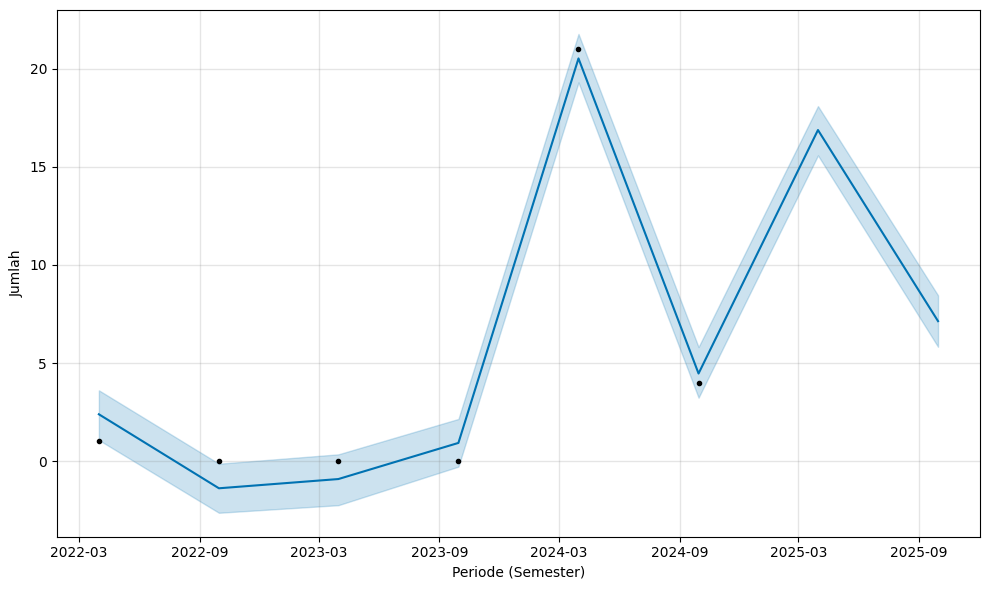

In [10]:
import matplotlib.pyplot as plt

future = model.make_future_dataframe(periods=2, freq="2Q")
forecast = model.predict(future)

fig = model.plot(forecast)
# plt.title(f"Forecast Kebutuhan Barang per Semester: {barang_df}")
plt.xlabel("Periode (Semester)")
plt.ylabel("Jumlah")
plt.show()

In [11]:
barang_df

,Nama Barang,ds,y
775,Kabel Roll (10M),2022-03-31,1.0
776,Kabel Roll (10M),2022-09-30,0.0
777,Kabel Roll (10M),2023-03-31,0.0
778,Kabel Roll (10M),2023-09-30,0.0
779,Kabel Roll (10M),2024-03-31,21.0
780,Kabel Roll (10M),2024-09-30,4.0


In [18]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2022-03-31,2.385520,1.071923,3.607583
1,2022-09-30,-1.388363,-2.637555,-0.135773
2,2023-03-31,-0.917629,-2.250307,0.342355
3,2023-09-30,0.925289,-0.283993,2.146596
4,2024-03-31,20.531253,19.308132,21.779998
5,2024-09-30,4.463931,3.230350,5.814208
6,2025-03-31,16.880566,15.588216,18.101119
7,2025-09-30,7.134436,5.826724,8.450254


In [12]:
forecast.tail(2)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
6,2025-03-31,16.880566,15.588216,18.101119
7,2025-09-30,7.134436,5.826724,8.450254


In [21]:
compare = barang_df[["ds", "y"]].merge(
    forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left"
)
compare

,ds,y,yhat,yhat_lower,yhat_upper
0,2022-03-31,1.0,2.385520,1.071923,3.607583
1,2022-09-30,0.0,-1.388363,-2.637555,-0.135773
2,2023-03-31,0.0,-0.917629,-2.250307,0.342355
3,2023-09-30,0.0,0.925289,-0.283993,2.146596
4,2024-03-31,21.0,20.531253,19.308132,21.779998
5,2024-09-30,4.0,4.463931,3.230350,5.814208


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(compare["y"], compare["yhat"])
rmse = root_mean_squared_error(compare["y"], compare["yhat"])

print(mae, rmse)

0.924913283544964 0.9983634358098351
